# TP2 - Detector de Máximo Enfoque

Implementación de un detector de máximo enfoque sobre video aplicando técnicas de análisis espectral.


In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

## Implementaciones de Métricas de Enfoque

### 1. Medida de Nitidez en Dominio de Frecuencia (Paper: "Image Sharpness Measure for Blurred Images in Frequency Domain")


In [2]:
def frequency_domain_sharpness(image):
    """
    Calculate sharpness measure in frequency domain.
    Based on: "Image Sharpness Measure for Blurred Images in Frequency Domain"
    
    The metric uses high-frequency components in the Fourier domain.
    Blurred images have less high-frequency content.
    """
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # image is M x N 
    M, N = image.shape

    # Step 1: Compute the Fourier Transform of the image
    f_transform = fft2(image)  # F (Fourier Transform)

    # Step 2: Shift the zero frequency component to the center
    f_shifted = fftshift(f_transform)  # Fc -> Shift zero frequency component to center

    # Step 3: Compute absolute value of the centered Fourier transform 
    a_f = np.abs(f_shifted)  # AF = abs(Fc)

    # Step 4: Find the maximum value of the frequency components
    max_value_of_freq_components = np.max(a_f)  # M = max(AF)
    
    # Step 5: Calculate T_H total number of pixels in F whose pixel value > thres, where thres = M/1000 
    thres = max_value_of_freq_components / 1000  # M/1000
    t_h = np.sum(a_f > thres)

    # Step 6: Compute Image Quality measure 
    fm = t_h / (M * N)

    return fm

### 2. Varianza del Laplaciano (Métrica Alternativa de Enfoque)


In [3]:
def variance_of_laplacian(image):
    """
    Calculate variance of Laplacian as focus measure.
    Alternative metric from "Analysis of focus measure operators in shape-from-focus"
    
    Sharp images have higher variance in Laplacian response.
    """
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    laplacian = cv.Laplacian(image, cv.CV_64F)
    variance = laplacian.var()
    
    return variance


### 3. Tenengrad (Magnitud del Gradiente)


In [4]:
def tenengrad(image, threshold=0):
    """
    Calculate Tenengrad focus measure.
    Sum of squared gradients above a threshold.
    """
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    sobel_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
    
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    if threshold > 0:
        gradient_magnitude = gradient_magnitude[gradient_magnitude > threshold]
    
    tenengrad_value = np.sum(gradient_magnitude**2)
    
    return tenengrad_value


## Funciones de Procesamiento de Video


In [5]:
def extract_roi_center(image, roi_percentage=0.1):
    """
    Extract Region of Interest from center of image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image
    roi_percentage : float
        Percentage of total area (0.05 for 5%, 0.1 for 10%)
    
    Returns:
    --------
    roi : np.ndarray
        Extracted ROI
    bbox : tuple
        (x, y, width, height) bounding box
    """
    height, width = image.shape[:2]
    total_area = height * width
    roi_area = total_area * roi_percentage
    
    roi_side = int(np.sqrt(roi_area))
    
    center_x, center_y = width // 2, height // 2
    
    x = center_x - roi_side // 2
    y = center_y - roi_side // 2
    
    roi = image[y:y+roi_side, x:x+roi_side]
    
    return roi, (x, y, roi_side, roi_side)


In [6]:
def create_focus_matrix(image, n_rows=3, n_cols=3):
    """
    Create a matrix of focus measurements from rectangular regions.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image
    n_rows : int
        Number of rows in the matrix
    n_cols : int
        Number of columns in the matrix
    
    Returns:
    --------
    focus_matrix : np.ndarray
        Matrix of focus values
    regions : list
        List of (x, y, w, h) tuples for each region
    """
    height, width = image.shape[:2]
    
    region_height = height // n_rows
    region_width = width // n_cols
    
    focus_matrix = np.zeros((n_rows, n_cols))
    regions = []
    
    for i in range(n_rows):
        for j in range(n_cols):
            y_start = i * region_height
            y_end = (i + 1) * region_height if i < n_rows - 1 else height
            x_start = j * region_width
            x_end = (j + 1) * region_width if j < n_cols - 1 else width
            
            region = image[y_start:y_end, x_start:x_end]
            focus_value = frequency_domain_sharpness(region)
            focus_matrix[i, j] = focus_value
            
            regions.append((x_start, y_start, x_end - x_start, y_end - y_start))
    
    return focus_matrix, regions


In [7]:
def detect_maximum_focus(focus_values, window_size=5):
    """
    Automatically detect frame with maximum focus.
    Uses a sliding window approach to find local maxima.
    
    Parameters:
    -----------
    focus_values : np.ndarray
        Array of focus values for each frame
    window_size : int
        Size of window for local maximum detection
    
    Returns:
    --------
    max_frame : int
        Frame index with maximum focus
    local_maxima : list
        List of frame indices with local maxima
    """
    focus_values = np.array(focus_values)
    
    max_frame = np.argmax(focus_values)
    
    local_maxima = []
    half_window = window_size // 2
    
    for i in range(half_window, len(focus_values) - half_window):
        window = focus_values[i - half_window:i + half_window + 1]
        if focus_values[i] == np.max(window) and focus_values[i] > np.mean(focus_values):
            local_maxima.append(i)
    
    return max_frame, local_maxima


In [8]:
def apply_unsharp_masking(image, sigma=1.0, strength=1.5):
    """
    Apply unsharp masking to enhance image sharpness.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image
    sigma : float
        Standard deviation for Gaussian blur
    strength : float
        Strength of sharpening
    
    Returns:
    --------
    sharpened : np.ndarray
        Sharpened image
    """
    if len(image.shape) == 3:
        blurred = cv.GaussianBlur(image, (0, 0), sigma)
        sharpened = cv.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    else:
        blurred = cv.GaussianBlur(image, (0, 0), sigma)
        sharpened = cv.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    
    return sharpened


## Experimento 1: Medición sobre Todo el Frame


In [9]:
def process_video_full_frame(video_path, focus_measure_func=frequency_domain_sharpness):
    """
    Process video and calculate focus measure for each full frame.
    
    Parameters:
    -----------
    video_path : str
        Path to video file
    focus_measure_func : callable
        Function to calculate focus measure
    
    Returns:
    --------
    focus_values : list
        List of focus values for each frame
    frames : list
        List of frame images
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    focus_values = []
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        focus_value = focus_measure_func(frame)
        focus_values.append(focus_value)
        frames.append(frame.copy())
        frame_count += 1
    
    cap.release()
    
    return focus_values, frames


In [10]:
video_path = 'focus_video.mov'

print("Processing video: Full Frame Measurement")
focus_values_full, frames_full = process_video_full_frame(video_path, frequency_domain_sharpness)

max_frame_full, local_maxima_full = detect_maximum_focus(focus_values_full)

print(f"Total frames processed: {len(focus_values_full)}")
print(f"Frame with maximum focus: {max_frame_full}")
print(f"Maximum focus value: {focus_values_full[max_frame_full]:.6f}")


Processing video: Full Frame Measurement
Total frames processed: 171
Frame with maximum focus: 109
Maximum focus value: 0.027843


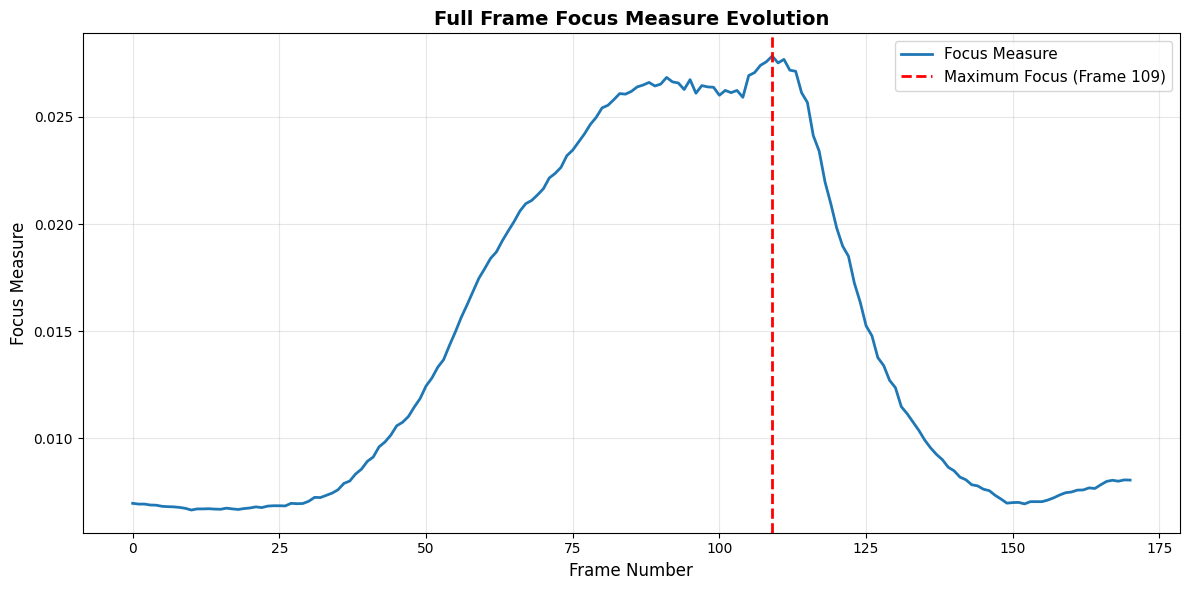

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(focus_values_full, linewidth=2, label='Focus Measure')
plt.axvline(x=max_frame_full, color='r', linestyle='--', linewidth=2, label=f'Maximum Focus (Frame {max_frame_full})')
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('Focus Measure', fontsize=12)
plt.title('Full Frame Focus Measure Evolution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


## Experimento 2: Medición sobre ROI Central


In [12]:
def process_video_roi(video_path, roi_percentage=0.1, focus_measure_func=frequency_domain_sharpness):
    """
    Process video and calculate focus measure for center ROI of each frame.
    
    Parameters:
    -----------
    video_path : str
        Path to video file
    roi_percentage : float
        Percentage of total area for ROI (0.05 for 5%, 0.1 for 10%)
    focus_measure_func : callable
        Function to calculate focus measure
    
    Returns:
    --------
    focus_values : list
        List of focus values for each frame
    rois : list
        List of ROI images
    bboxes : list
        List of bounding boxes (x, y, w, h)
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    focus_values = []
    rois = []
    bboxes = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        roi, bbox = extract_roi_center(frame, roi_percentage)
        focus_value = focus_measure_func(roi)
        
        focus_values.append(focus_value)
        rois.append(roi.copy())
        bboxes.append(bbox)
    
    cap.release()
    
    return focus_values, rois, bboxes


In [13]:
print("Processing video: Center ROI Measurement (10%)")
focus_values_roi_10, rois_10, bboxes_10 = process_video_roi(video_path, roi_percentage=0.1, focus_measure_func=frequency_domain_sharpness)

max_frame_roi_10, local_maxima_roi_10 = detect_maximum_focus(focus_values_roi_10)

print(f"Total frames processed: {len(focus_values_roi_10)}")
print(f"Frame with maximum focus: {max_frame_roi_10}")
print(f"Maximum focus value: {focus_values_roi_10[max_frame_roi_10]:.6f}")


Processing video: Center ROI Measurement (10%)
Total frames processed: 171
Frame with maximum focus: 111
Maximum focus value: 0.340818


In [14]:
print("Processing video: Center ROI Measurement (5%)")
focus_values_roi_5, rois_5, bboxes_5 = process_video_roi(video_path, roi_percentage=0.05, focus_measure_func=frequency_domain_sharpness)

max_frame_roi_5, local_maxima_roi_5 = detect_maximum_focus(focus_values_roi_5)

print(f"Total frames processed: {len(focus_values_roi_5)}")
print(f"Frame with maximum focus: {max_frame_roi_5}")
print(f"Maximum focus value: {focus_values_roi_5[max_frame_roi_5]:.6f}")


Processing video: Center ROI Measurement (5%)
Total frames processed: 171
Frame with maximum focus: 111
Maximum focus value: 0.463883


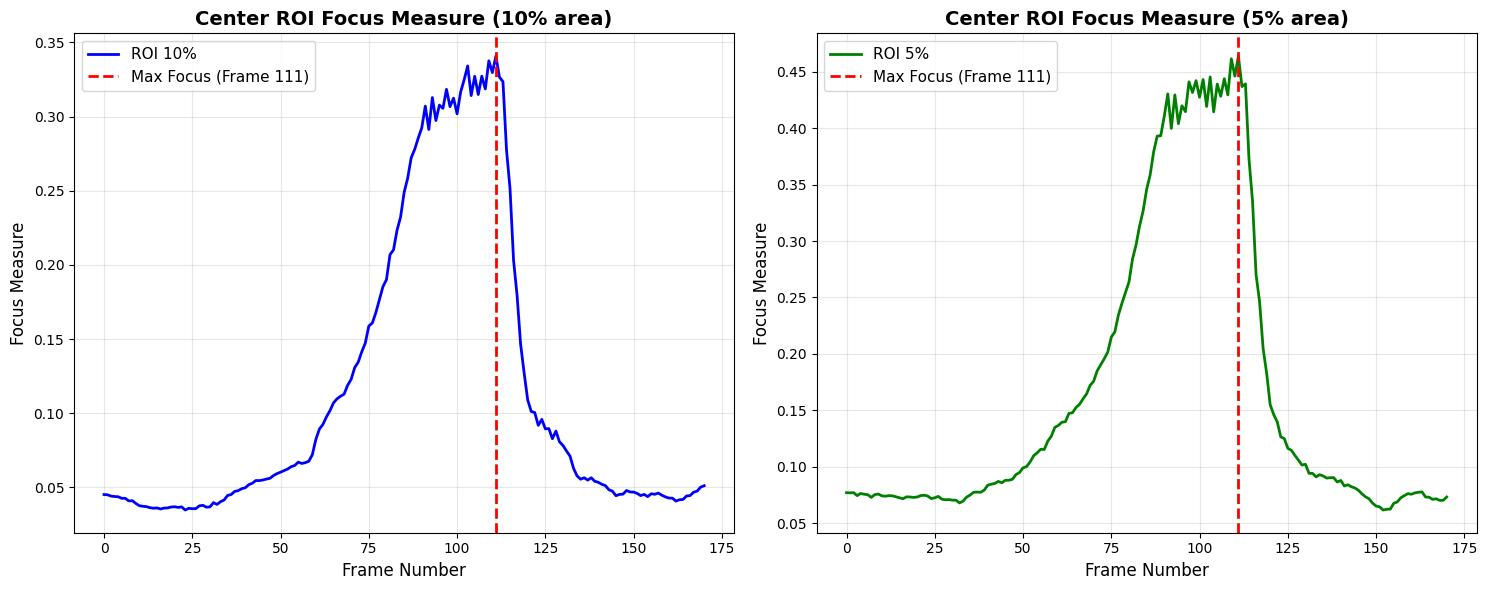

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(focus_values_roi_10, linewidth=2, label='ROI 10%', color='blue')
axes[0].axvline(x=max_frame_roi_10, color='r', linestyle='--', linewidth=2, label=f'Max Focus (Frame {max_frame_roi_10})')
axes[0].set_xlabel('Frame Number', fontsize=12)
axes[0].set_ylabel('Focus Measure', fontsize=12)
axes[0].set_title('Center ROI Focus Measure (10% area)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

axes[1].plot(focus_values_roi_5, linewidth=2, label='ROI 5%', color='green')
axes[1].axvline(x=max_frame_roi_5, color='r', linestyle='--', linewidth=2, label=f'Max Focus (Frame {max_frame_roi_5})')
axes[1].set_xlabel('Frame Number', fontsize=12)
axes[1].set_ylabel('Focus Measure', fontsize=12)
axes[1].set_title('Center ROI Focus Measure (5% area)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


## Experimento 3: Medición sobre Matriz de Enfoque


In [16]:
def process_video_focus_matrix(video_path, n_rows=3, n_cols=3, focus_measure_func=frequency_domain_sharpness):
    """
    Process video and calculate focus matrix for each frame.
    
    Parameters:
    -----------
    video_path : str
        Path to video file
    n_rows : int
        Number of rows in focus matrix
    n_cols : int
        Number of columns in focus matrix
    focus_measure_func : callable
        Function to calculate focus measure
    
    Returns:
    --------
    focus_matrices : list
        List of focus matrices (one per frame)
    average_focus_values : list
        List of average focus values across matrix
    max_focus_values : list
        List of maximum focus values in matrix
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    focus_matrices = []
    average_focus_values = []
    max_focus_values = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        focus_matrix, _ = create_focus_matrix(frame, n_rows, n_cols)
        focus_matrices.append(focus_matrix)
        
        average_focus = np.mean(focus_matrix)
        max_focus = np.max(focus_matrix)
        
        average_focus_values.append(average_focus)
        max_focus_values.append(max_focus)
    
    cap.release()
    
    return focus_matrices, average_focus_values, max_focus_values


In [17]:
matrix_configs = [(3, 3), (7, 5), (5, 7)]

focus_matrix_results = {}

for n_rows, n_cols in matrix_configs:
    print(f"\nProcessing video: Focus Matrix {n_rows}x{n_cols}")
    matrices, avg_values, max_values = process_video_focus_matrix(
        video_path, n_rows=n_rows, n_cols=n_cols, focus_measure_func=frequency_domain_sharpness
    )
    
    max_frame_avg = np.argmax(avg_values)
    max_frame_max = np.argmax(max_values)
    
    focus_matrix_results[(n_rows, n_cols)] = {
        'matrices': matrices,
        'average_values': avg_values,
        'max_values': max_values,
        'max_frame_avg': max_frame_avg,
        'max_frame_max': max_frame_max
    }
    
    print(f"Frame with maximum average focus: {max_frame_avg}")
    print(f"Frame with maximum peak focus: {max_frame_max}")



Processing video: Focus Matrix 3x3
Frame with maximum average focus: 111
Frame with maximum peak focus: 103

Processing video: Focus Matrix 7x5
Frame with maximum average focus: 99
Frame with maximum peak focus: 86

Processing video: Focus Matrix 5x7
Frame with maximum average focus: 111
Frame with maximum peak focus: 111


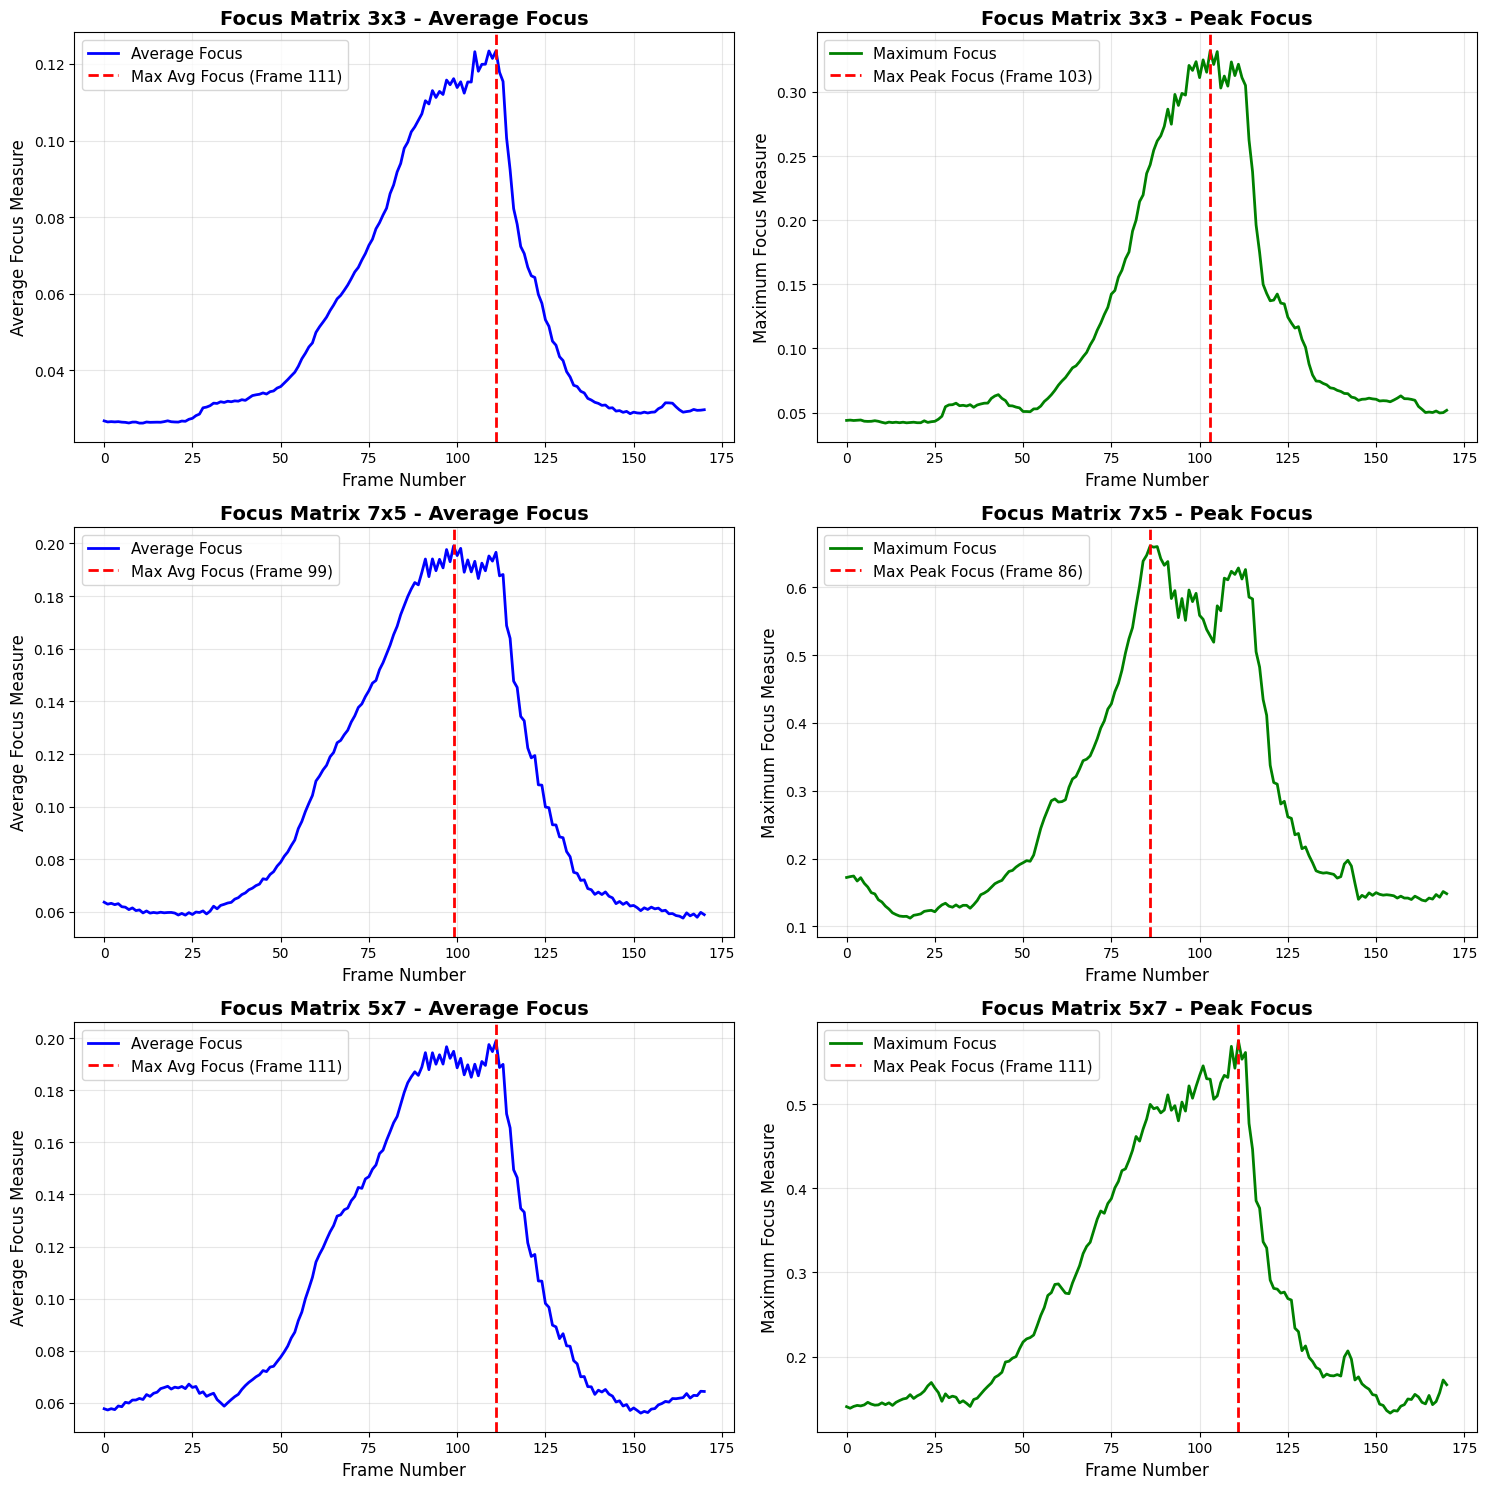

In [18]:
fig, axes = plt.subplots(len(matrix_configs), 2, figsize=(15, 5 * len(matrix_configs)))

for idx, (n_rows, n_cols) in enumerate(matrix_configs):
    results = focus_matrix_results[(n_rows, n_cols)]
    
    axes[idx, 0].plot(results['average_values'], linewidth=2, label='Average Focus', color='blue')
    axes[idx, 0].axvline(x=results['max_frame_avg'], color='r', linestyle='--', 
                         linewidth=2, label=f'Max Avg Focus (Frame {results["max_frame_avg"]})')
    axes[idx, 0].set_xlabel('Frame Number', fontsize=12)
    axes[idx, 0].set_ylabel('Average Focus Measure', fontsize=12)
    axes[idx, 0].set_title(f'Focus Matrix {n_rows}x{n_cols} - Average Focus', fontsize=14, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].legend(fontsize=11)
    
    axes[idx, 1].plot(results['max_values'], linewidth=2, label='Maximum Focus', color='green')
    axes[idx, 1].axvline(x=results['max_frame_max'], color='r', linestyle='--', 
                         linewidth=2, label=f'Max Peak Focus (Frame {results["max_frame_max"]})')
    axes[idx, 1].set_xlabel('Frame Number', fontsize=12)
    axes[idx, 1].set_ylabel('Maximum Focus Measure', fontsize=12)
    axes[idx, 1].set_title(f'Focus Matrix {n_rows}x{n_cols} - Peak Focus', fontsize=14, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].legend(fontsize=11)

plt.tight_layout()
plt.show()


## Métrica Alternativa de Enfoque: Varianza del Laplaciano

### Justificación de la Elección

Se eligió la **Varianza del Laplaciano** como métrica alternativa según lo solicitado en la consigna, basándose en el apéndice del paper "Analysis of focus measure operators in shape-from-focus". Esta métrica fue seleccionada por las siguientes razones:

1. **Eficiencia computacional**: A diferencia de la métrica en dominio de frecuencia que requiere una transformada de Fourier completa, el Laplaciano se calcula mediante una convolución simple con un kernel pequeño (3x3), lo que lo hace significativamente más rápido para procesar videos.

2. **Robustez**: El operador Laplaciano es un detector de bordes de segundo orden que responde fuertemente a cambios abruptos en la intensidad. Las imágenes nítidas tienen bordes bien definidos, resultando en una mayor varianza en la respuesta del Laplaciano, mientras que las imágenes desenfocadas producen respuestas más suaves y uniformes.

3. **Complementariedad**: Esta métrica opera en el dominio espacial, proporcionando una perspectiva diferente a la métrica en dominio de frecuencia. Esto permite comparar y validar los resultados obtenidos con diferentes enfoques teóricos.

4. **Simplicidad e interpretabilidad**: La varianza del Laplaciano es una métrica intuitiva y fácil de interpretar: valores altos indican imágenes nítidas con muchos bordes definidos, mientras que valores bajos sugieren imágenes desenfocadas.

5. **Reconocimiento en la literatura**: Esta métrica es ampliamente reconocida y utilizada en aplicaciones de autofocus y detección de enfoque, siendo una de las métricas más citadas en el paper de referencia.


In [19]:
print("Processing video with Variance of Laplacian metric: Full Frame")
focus_values_laplacian, _ = process_video_full_frame(video_path, focus_measure_func=variance_of_laplacian)

max_frame_laplacian, local_maxima_laplacian = detect_maximum_focus(focus_values_laplacian)

print(f"Total frames processed: {len(focus_values_laplacian)}")
print(f"Frame with maximum focus: {max_frame_laplacian}")
print(f"Maximum focus value: {focus_values_laplacian[max_frame_laplacian]:.6f}")


Processing video with Variance of Laplacian metric: Full Frame
Total frames processed: 171
Frame with maximum focus: 111
Maximum focus value: 109.227195


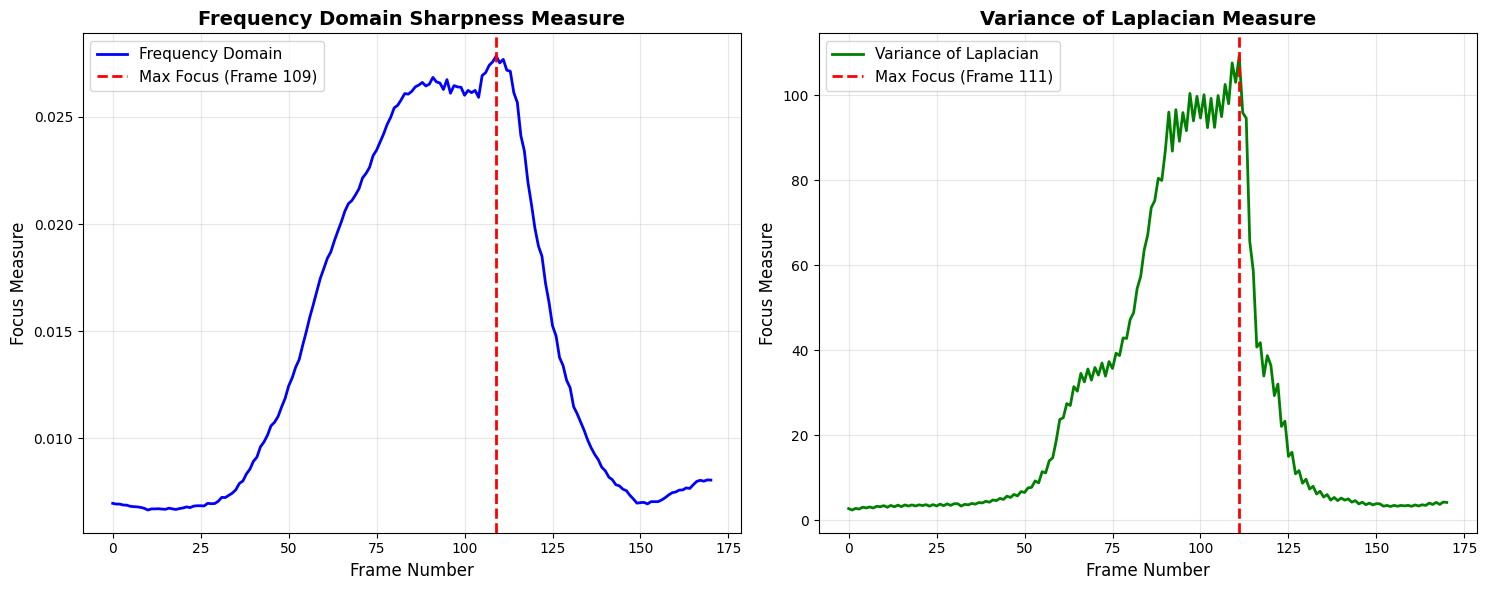

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(focus_values_full, linewidth=2, label='Frequency Domain', color='blue')
axes[0].axvline(x=max_frame_full, color='r', linestyle='--', linewidth=2, label=f'Max Focus (Frame {max_frame_full})')
axes[0].set_xlabel('Frame Number', fontsize=12)
axes[0].set_ylabel('Focus Measure', fontsize=12)
axes[0].set_title('Frequency Domain Sharpness Measure', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

axes[1].plot(focus_values_laplacian, linewidth=2, label='Variance of Laplacian', color='green')
axes[1].axvline(x=max_frame_laplacian, color='r', linestyle='--', linewidth=2, label=f'Max Focus (Frame {max_frame_laplacian})')
axes[1].set_xlabel('Frame Number', fontsize=12)
axes[1].set_ylabel('Focus Measure', fontsize=12)
axes[1].set_title('Variance of Laplacian Measure', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


## Bonus: Mejora con Unsharp Masking


In [21]:
def process_video_with_unsharp_masking(video_path, sigma=1.0, strength=1.5, focus_measure_func=frequency_domain_sharpness):
    """
    Process video with unsharp masking applied before focus measurement.
    
    Parameters:
    -----------
    video_path : str
        Path to video file
    sigma : float
        Standard deviation for Gaussian blur in unsharp masking
    strength : float
        Strength of sharpening
    focus_measure_func : callable
        Function to calculate focus measure
    
    Returns:
    --------
    focus_values : list
        List of focus values for each frame
    enhanced_frames : list
        List of enhanced frame images
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    focus_values = []
    enhanced_frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        enhanced_frame = apply_unsharp_masking(frame, sigma=sigma, strength=strength)
        focus_value = focus_measure_func(enhanced_frame)
        
        focus_values.append(focus_value)
        enhanced_frames.append(enhanced_frame.copy())
    
    cap.release()
    
    return focus_values, enhanced_frames


In [22]:
print("Processing video with Unsharp Masking enhancement")
focus_values_unsharp, enhanced_frames = process_video_with_unsharp_masking(
    video_path, sigma=1.0, strength=1.5, focus_measure_func=frequency_domain_sharpness
)

max_frame_unsharp, local_maxima_unsharp = detect_maximum_focus(focus_values_unsharp)

print(f"Total frames processed: {len(focus_values_unsharp)}")
print(f"Frame with maximum focus: {max_frame_unsharp}")
print(f"Maximum focus value: {focus_values_unsharp[max_frame_unsharp]:.6f}")


Processing video with Unsharp Masking enhancement
Total frames processed: 171
Frame with maximum focus: 111
Maximum focus value: 0.047010


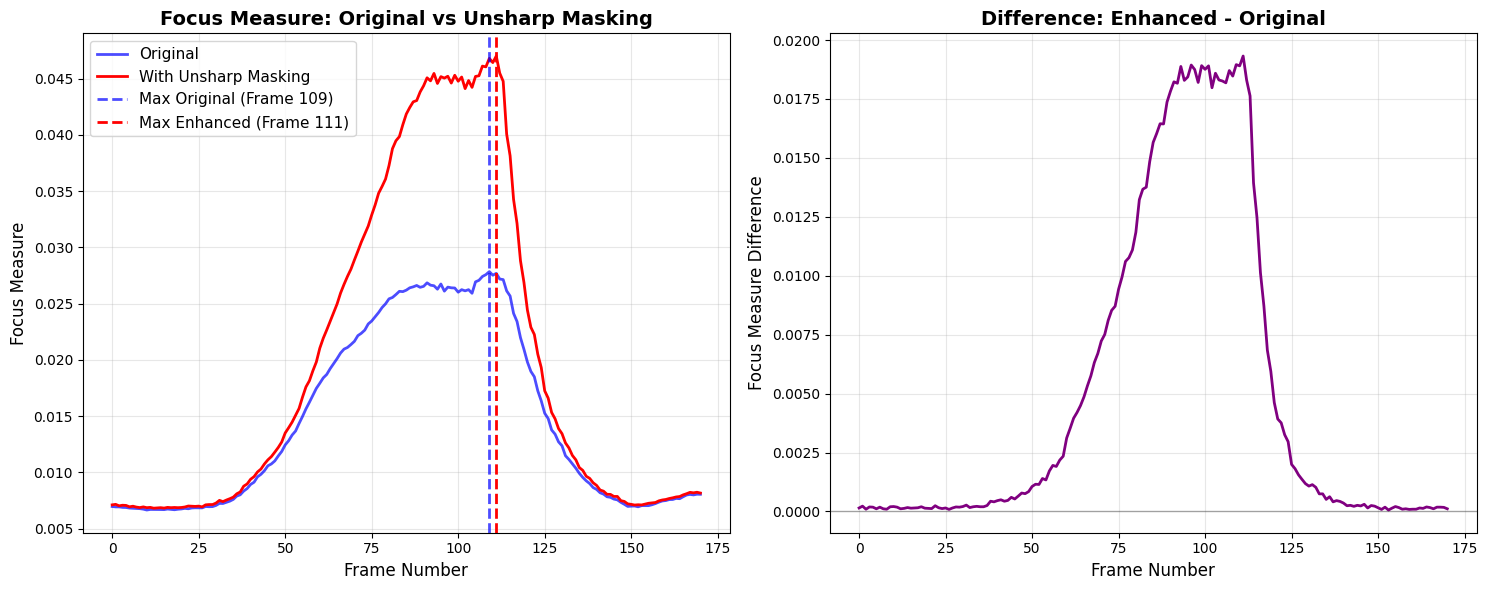

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(focus_values_full, linewidth=2, label='Original', color='blue', alpha=0.7)
axes[0].plot(focus_values_unsharp, linewidth=2, label='With Unsharp Masking', color='red')
axes[0].axvline(x=max_frame_full, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Max Original (Frame {max_frame_full})')
axes[0].axvline(x=max_frame_unsharp, color='red', linestyle='--', linewidth=2, label=f'Max Enhanced (Frame {max_frame_unsharp})')
axes[0].set_xlabel('Frame Number', fontsize=12)
axes[0].set_ylabel('Focus Measure', fontsize=12)
axes[0].set_title('Focus Measure: Original vs Unsharp Masking', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

difference = np.array(focus_values_unsharp) - np.array(focus_values_full)
axes[1].plot(difference, linewidth=2, color='purple')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[1].set_xlabel('Frame Number', fontsize=12)
axes[1].set_ylabel('Focus Measure Difference', fontsize=12)
axes[1].set_title('Difference: Enhanced - Original', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Resumen y Resultados

### Resultados de Detección Automática de Enfoque

La siguiente tabla resume los frames con máximo enfoque detectados para cada experimento:


In [24]:
results_summary = {
    'Experiment': [
        'Full Frame (Frequency Domain)',
        'Full Frame (Variance of Laplacian)',
        'Center ROI 10%',
        'Center ROI 5%',
        'Focus Matrix 3x3 (Average)',
        'Focus Matrix 7x5 (Average)',
        'Focus Matrix 5x7 (Average)',
        'Unsharp Masking Enhanced'
    ],
    'Max Focus Frame': [
        max_frame_full,
        max_frame_laplacian,
        max_frame_roi_10,
        max_frame_roi_5,
        focus_matrix_results[(3, 3)]['max_frame_avg'],
        focus_matrix_results[(7, 5)]['max_frame_avg'],
        focus_matrix_results[(5, 7)]['max_frame_avg'],
        max_frame_unsharp
    ],
    'Focus Value': [
        f"{focus_values_full[max_frame_full]:.6f}",
        f"{focus_values_laplacian[max_frame_laplacian]:.6f}",
        f"{focus_values_roi_10[max_frame_roi_10]:.6f}",
        f"{focus_values_roi_5[max_frame_roi_5]:.6f}",
        f"{focus_matrix_results[(3, 3)]['average_values'][focus_matrix_results[(3, 3)]['max_frame_avg']]:.6f}",
        f"{focus_matrix_results[(7, 5)]['average_values'][focus_matrix_results[(7, 5)]['max_frame_avg']]:.6f}",
        f"{focus_matrix_results[(5, 7)]['average_values'][focus_matrix_results[(5, 7)]['max_frame_avg']]:.6f}",
        f"{focus_values_unsharp[max_frame_unsharp]:.6f}"
    ]
}

print("\n" + "="*80)
print("AUTOMATIC FOCUS DETECTION SUMMARY")
print("="*80)
for i, exp in enumerate(results_summary['Experiment']):
    print(f"{exp:40s} | Frame: {results_summary['Max Focus Frame'][i]:4d} | Value: {results_summary['Focus Value'][i]}")
print("="*80)



AUTOMATIC FOCUS DETECTION SUMMARY
Full Frame (Frequency Domain)            | Frame:  109 | Value: 0.027843
Full Frame (Variance of Laplacian)       | Frame:  111 | Value: 109.227195
Center ROI 10%                           | Frame:  111 | Value: 0.340818
Center ROI 5%                            | Frame:  111 | Value: 0.463883
Focus Matrix 3x3 (Average)               | Frame:  111 | Value: 0.123394
Focus Matrix 7x5 (Average)               | Frame:   99 | Value: 0.199048
Focus Matrix 5x7 (Average)               | Frame:  111 | Value: 0.198903
Unsharp Masking Enhanced                 | Frame:  111 | Value: 0.047010
